In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Load Dataset

In [2]:
from datasets import load_dataset

# Load SST-2
dataset = load_dataset("stanfordnlp/sst2")

In [3]:
import pandas as pd


df_train = pd.DataFrame(dataset["train"])
input_text = df_train["sentence"].head().tolist()
input_text

['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ',
 'remains utterly satisfied to remain the same throughout ',
 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ']

In [4]:
from transformers import AutoTokenizer, AutoModel
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

In [5]:
inp_tokens = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt")

tokens = inp_tokens["input_ids"]
tokens.shape

torch.Size([5, 22])

### Embedding

In [6]:
x_emb = bert_model.embeddings(tokens)
x_emb.shape

torch.Size([5, 22, 768])

In [7]:
D = bert_model.config.hidden_size
D

768

In [8]:
B = 5
T = 22
N = 12
assert D % N == 0
dh = D // N
dh

64

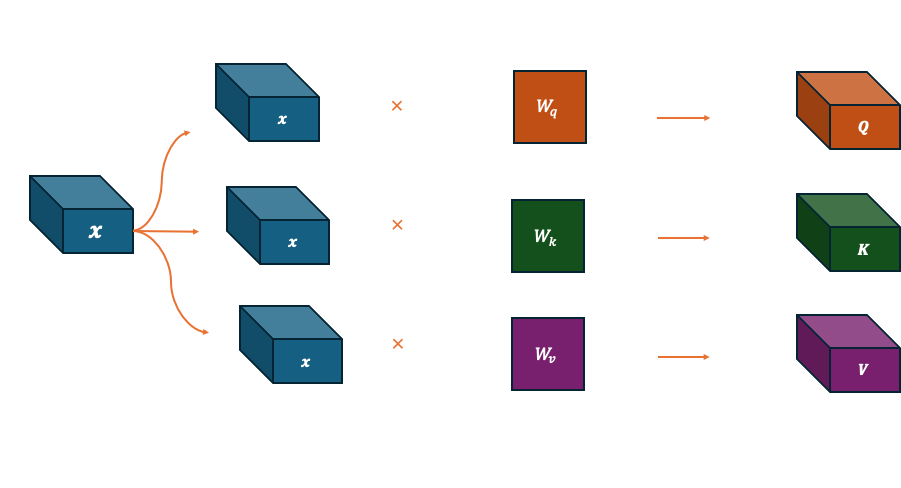

In [ ]:
Wq = nn.Linear(D, D)
Wk = nn.Linear(D, D)
Wv = nn.Linear(D, D)

q = Wq(x_emb)
k = Wk(x_emb)
v = Wv(x_emb)

### Single Linear Layer

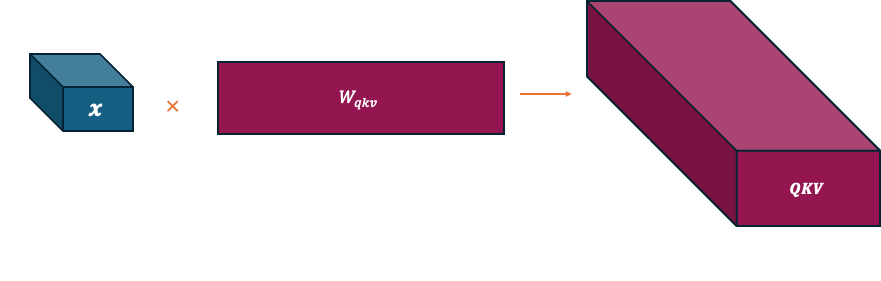

In [25]:
Wqkv = nn.Linear(D, 3 * D)

Transformations

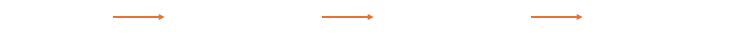

In [26]:
qkv = Wqkv(x_emb)

qkv.shape # B T 3D

torch.Size([5, 22, 2304])

In [30]:
q, k, v = qkv.view(B, T, N, 3 * dh).transpose(1, 2).chunk(3, dim=-1)

q.shape # B N T dh

torch.Size([5, 12, 22, 64])

In [34]:
import math


attn = q @ k.transpose(-2, -1)
scale_factor = 1 / math.sqrt(dh)
outh = (F.softmax(attn * scale_factor, dim=-1) @ v) # B N T dh
outh.shape

torch.Size([5, 12, 22, 64])

In [36]:
outh2 = F.scaled_dot_product_attention(q, k, v)

In [38]:
mask = torch.tril(torch.ones(T, T, dtype=torch.bool))

outh2 = F.scaled_dot_product_attention(q, k, v, attn_mask=~mask)
outh2.shape

torch.Size([5, 12, 22, 64])